Датасет: данные о продажах напитков.
Таргет: "quantity"

Задание:
* 1) Провести EDA (анализ данных) с визуализацией.

* 2) Построить модель для прогнозирования таргета ("quantity")

Как результат должен быть .ipynb файл (или несколько) с анализом и процессом создания модели.
В файле должны содержаться комментарии и промежуточные мысли / выводы по ходу выполнения, обоснование выбора финального подхода и предложения по его дальнейшему улучшению.
+ Проскорений файл test_.csv с проставленным прогнозируемым значением таргету ("quantity").

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy import stats

# from IPython.display import display
# from pandas.api.types import CategoricalDtype
# import pandas.util.testing as tm

# from category_encoders import MEstimateEncoder
# from category_encoders import CatBoostEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

In [5]:
# чтение данных
path_train_drinks = "/content/drive/MyDrive/Colab Notebooks/data/train_drinks.csv"
path_test_drinks = "/content/drive/MyDrive/Colab Notebooks/data/test_drinks.csv"

df_train = pd.read_csv(path_train_drinks)
df_test = pd.read_csv(path_test_drinks)

In [6]:
# Объединим датасеты для совместной обработки
df = pd.concat([df_train, df_test], ignore_index=True)

# 1. Чистка, кодировка и замена данных

In [7]:
df_train.head(5)

,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,glass,500ml,0.96,13280.0
1,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,plastic,1.5lt,2.86,6727.0
2,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,can,330ml,0.87,9848.0
3,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,glass,500ml,1.00,20050.0
4,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,can,330ml,NaN,25696.0


In [8]:
# анализ и преобразование дат
# проверим "одинаковость" всех значений. Ок, все 7560 значений имеют одинаковую длинну, можно преобразовывать
date_lengths=df.date.str.len()
date_lengths.value_counts()

8    7560
Name: date, dtype: int64

In [11]:
# преобразование obj -> datetime64

df['date'] = pd.to_datetime(df['date'], format="%d/%m/%y")
df['date']

0      2012-01-31
1      2012-01-31
2      2012-01-31
3      2012-01-31
4      2012-01-31
          ...    
7555   2018-12-31
7556   2018-12-31
7557   2018-12-31
7558   2018-12-31
7559   2018-12-31
Name: date, Length: 7560, dtype: datetime64[ns]

In [12]:
# проверка количество значений 0.
(df_train == 0).sum()

# результат - 0 отсутствуют, отлично.

date         0
city         0
lat          0
long         0
pop          0
shop         0
brand        0
container    0
capacity     0
price        0
quantity     0
dtype: int64

In [13]:
# проверка на наличие дубликатов строк. 
df_train.duplicated().value_counts()

# результат - False по всем 6480 строкам, т.е. дублей строк нет, отлично.

False    6480
dtype: int64

In [14]:
# разбираемся с предикторами.
# какие у нас столбцы, сколько в них уникальных значений, возможные связи..
# напр установил, что даты, это последний день каждого месяца за 6 лет (12*6=72 значения), в Athens 2 магазина, в остальных по одному, 
# координаты - это координаты магазинов, каждому типу емкости соответствует свой объем.

df_train.columns

Index(['date', 'city', 'lat', 'long', 'pop', 'shop', 'brand', 'container',
       'capacity', 'price', 'quantity'],
      dtype='object')

In [15]:
df_train.shop.unique()

array(['shop_1', 'shop_2', 'shop_6', 'shop_4', 'shop_3', 'shop_5'],
      dtype=object)

In [16]:
# сводная таблица магазинов и их координат
pd.pivot_table(df_train, index=["shop"], values=["lat", "long"])

# т.к. 'lat' и 'long' это координаты "shop" => данные мультиколлинеарны => координаты 'lat' и 'long' не будем использовать для обучения.

,lat,long
shop,,
shop_1,37.97945,23.71622
shop_2,35.32787,25.14341
shop_3,37.96245,23.68708
shop_4,40.64361,22.93086
shop_5,39.63689,22.41761
shop_6,38.24444,21.73444


In [17]:
'''проверка отсутствующих значений.'''
df_train.isnull().sum()

# результат - множество Nan значений, далее будет проведена работа по их чистке и замене.

date           0
city           0
lat           51
long          46
pop            0
shop           0
brand        201
container     16
capacity      15
price        149
quantity       0
dtype: int64

# 2. Замена Nan

In [19]:
# % пропущенных значений.
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

# в данном случае % пропущенных значений очень малый, будем делать замены. В случае >80% пропущенных значений нужно рассматривать вариант удаления такого предиктора, т.к. замены такого объема могут привести к искажению. 

,Total,Percent
brand,201,0.031019
price,149,0.022994
lat,51,0.007870
long,46,0.007099
container,16,0.002469
capacity,15,0.002315
quantity,0,0.000000
shop,0,0.000000
pop,0,0.000000
city,0,0.000000


In [20]:
df.loc[df['container'] == 'plastic']
# похоже, что есть соответствие типа емкости и объема can-330ml, glass-500ml, plastic-1.5lt (фильтруя по титу получаем в уникальных по 1му элементу) можно сделать точные замены пропущенных значений.

,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
1,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,plastic,1.5lt,2.86,6727.0
9,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,lemon-boost,plastic,1.5lt,2.21,9645.0
12,2012-01-31,Irakleion,35.32787,25.14341,134219.0,shop_2,kinder-cola,plastic,1.5lt,1.62,15073.0
18,2012-01-31,Irakleion,35.32787,25.14341,134219.0,shop_2,gazoza,plastic,1.5lt,1.00,30757.0
21,2012-01-31,Irakleion,35.32787,25.14341,134219.0,shop_2,lemon-boost,plastic,1.5lt,2.25,10348.0
...,...,...,...,...,...,...,...,...,...,...,...
7553,2018-12-31,Irakleion,35.32787,25.14341,137154.0,shop_2,adult-cola,plastic,1.5lt,2.36,NaN
7554,2018-12-31,Athens,37.96245,23.68708,664046.0,shop_3,kinder-cola,plastic,1.5lt,1.91,NaN
7555,2018-12-31,Athens,37.97945,23.71622,664046.0,shop_1,kinder-cola,plastic,1.5lt,2.52,NaN
7556,2018-12-31,Athens,37.97945,23.71622,664046.0,shop_1,orange-power,plastic,1.5lt,2.18,NaN


In [21]:
df.loc[df['container'] == 'can'].nunique()

date           84
city            5
lat             6
long            6
pop            35
shop            6
brand           5
container       1
capacity        1
price          94
quantity     2112
dtype: int64

In [22]:
# вывод строк с пропущенными значениями в столбце 'capacity'
df[df['capacity'].isnull()]

,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
1553,2013-06-30,Patra,38.24444,21.73444,166301.0,shop_6,kinder-cola,glass,NaN,1.46,25634.0
1847,2013-09-30,Thessaloniki,40.64361,22.93086,347001.0,shop_4,gazoza,plastic,NaN,0.93,42320.0
2584,2014-05-31,Athens,37.96245,23.68708,668203.0,shop_3,lemon-boost,glass,NaN,0.61,27136.0
3040,2014-10-31,Larisa,39.63689,22.41761,140563.0,shop_5,NaN,can,NaN,0.69,21225.0
3246,2015-01-31,Athens,37.97945,23.71622,667237.0,shop_1,gazoza,glass,NaN,0.51,46809.0
3624,2015-05-31,Patra,38.24444,21.73444,167001.0,shop_6,NaN,glass,NaN,1.06,49039.0
4450,2016-02-29,Thessaloniki,40.64361,22.93086,351702.0,shop_4,orange-power,glass,NaN,0.70,34008.0
4776,2016-06-30,Athens,37.97945,23.71622,665102.0,shop_1,orange-power,plastic,NaN,1.88,26675.0
4812,2016-06-30,Thessaloniki,40.64361,22.93086,351702.0,shop_4,gazoza,glass,NaN,0.77,40645.0
4868,2016-07-31,Athens,37.97945,23.71622,665102.0,shop_1,orange-power,can,NaN,0.60,41847.0


In [23]:
# сделаем точные замены пропущенных значений.
df.loc[df['capacity'] == '330ml', 'container'] = 'can'
df.loc[df['capacity'] == '500ml', 'container'] = 'glass'
df.loc[df['capacity'] == '1.5lt', 'container'] = 'plastic'
df.loc[df['container'] == 'can', 'capacity'] = '330ml'
df.loc[df['container'] == 'glass', 'capacity'] = '500ml'
df.loc[df['container'] == 'plastic', 'capacity'] = '1.5lt'

In [24]:
# проверим отработку замены Nan в container и capacity        
df.isnull().sum()

# все ок, 0 значений.

date            0
city            0
lat            59
long           59
pop             0
shop            0
brand         238
container       0
capacity        0
price         180
quantity     1080
dtype: int64

In [25]:
# замена пропущенных значений координат согласно координатам маказинов
df.loc[df['shop'] == 'shop_1', 'lat'] = '37.97945'
df.loc[df['shop'] == 'shop_1', 'long'] = '23.71622'
df.loc[df['shop'] == 'shop_2', 'lat'] = '35.32787'
df.loc[df['shop'] == 'shop_2', 'long'] = '25.14341'
df.loc[df['shop'] == 'shop_3', 'lat'] = '37.96245'
df.loc[df['shop'] == 'shop_3', 'long'] = '23.68708'
df.loc[df['shop'] == 'shop_4', 'lat'] = '40.64361'
df.loc[df['shop'] == 'shop_4', 'long'] = '22.93086'
df.loc[df['shop'] == 'shop_5', 'lat'] = '39.63689'
df.loc[df['shop'] == 'shop_5', 'long'] = '22.41761'
df.loc[df['shop'] == 'shop_6', 'lat'] = '38.24444'
df.loc[df['shop'] == 'shop_6', 'long'] = '21.73444'

In [26]:
# вывод строк с пропущенными значениями в столбце brand 
df.loc[df['brand'].isnull()]

,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
26,2012-01-31,Patra,38.24444,21.73444,164250.0,shop_6,NaN,glass,500ml,1.17,19841.0
30,2012-01-31,Patra,38.24444,21.73444,164250.0,shop_6,NaN,can,330ml,0.33,66314.0
86,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,NaN,plastic,1.5lt,0.85,26884.0
95,2012-02-29,Athens,37.97945,23.71622,672130.0,shop_1,NaN,plastic,1.5lt,2.51,5777.0
146,2012-02-29,Athens,37.96245,23.68708,672130.0,shop_3,NaN,plastic,1.5lt,1.37,10071.0
...,...,...,...,...,...,...,...,...,...,...,...
7420,2018-11-30,Thessaloniki,40.64361,22.93086,354290.0,shop_4,NaN,glass,500ml,0.99,NaN
7421,2018-11-30,Thessaloniki,40.64361,22.93086,354290.0,shop_4,NaN,plastic,1.5lt,1.20,NaN
7482,2018-12-31,Irakleion,35.32787,25.14341,137154.0,shop_2,NaN,plastic,1.5lt,2.06,NaN
7491,2018-12-31,Irakleion,35.32787,25.14341,137154.0,shop_2,NaN,glass,500ml,0.85,NaN


In [27]:
# замена Nan в 'brand' на следующее за ним значение (следующее значение выбрал исходя из визуального анализа датасета df, это будет значительно эффективнее чем заполнить все модой или медианой).
# df1.brand.fillna(df1.brand.value_counts().idxmax())
# df1.isnull().sum()

df['brand'].fillna(method="bfill", inplace=True)

In [29]:
df.isnull().sum()

date            0
city            0
lat             0
long            0
pop             0
shop            0
brand           0
container       0
capacity        0
price         180
quantity     1080
dtype: int64

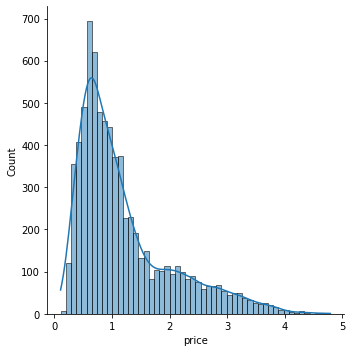

In [30]:
# распределение цен "price"
sns.displot(df["price"], kde=True)

In [31]:
# исходя из графика распределения замена Nan на среднее значение, будет не такой точной, как если заменить на медианное.
df["price"].fillna(df["price"].median(skipna=True), inplace=True)

In [32]:
df.isnull().sum()

date            0
city            0
lat             0
long            0
pop             0
shop            0
brand           0
container       0
capacity        0
price           0
quantity     1080
dtype: int64

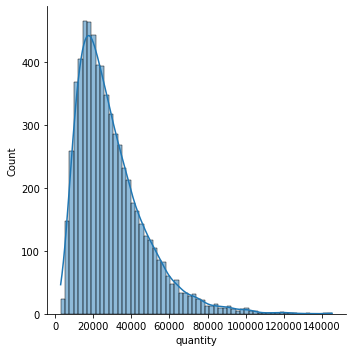

In [33]:
# распределение цен "quantity"
sns.displot(df_train["quantity"], kde=True)

In [34]:
# исходя из графика распределения если мы заменить Nan среднее значение, оно будет не таким точным, как если заменить на медианное (аналогично price)
df["quantity"].fillna(df["quantity"].median(skipna=True), inplace=True)

In [35]:
# проверка наличия пустых значений
df.isnull().sum()

date         0
city         0
lat          0
long         0
pop          0
shop         0
brand        0
container    0
capacity     0
price        0
quantity     0
dtype: int64

In [36]:
# разъединим ранее соединенные датасеты
df_train = df.loc[: 6479]
df_test = df.loc[6480 :].reset_index(drop=True)
# df_test = df_test.drop('quantity', axis=1, inplace=True)

In [37]:
# удаление столбца 'quantity' в df_test, который появился после слияния с df_train
del df_test['quantity']

# 3. Выбросы (поиск и анализ)

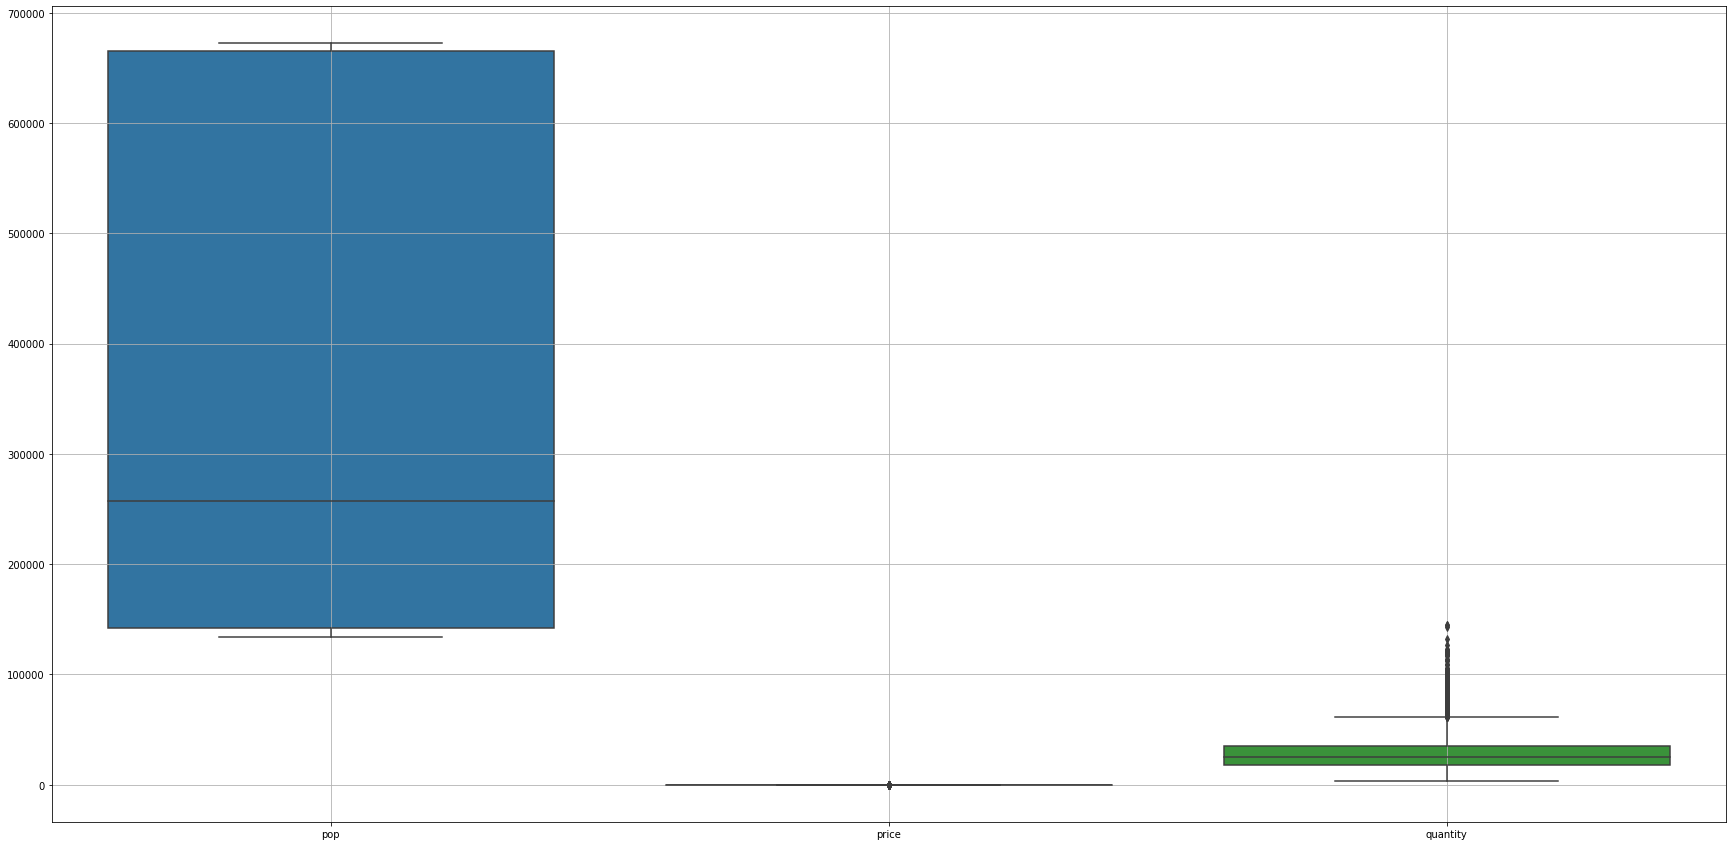

In [40]:
# рассмотрим числовые предикторы на наличие выбровов и проанализируем их
plt.figure(figsize=(30,15))
sns.boxplot(data=df)
plt.grid(True)

# предикторы lat и long опустим, т.к. не будем их использовать в дальнейшем (дубль предиктора shop)

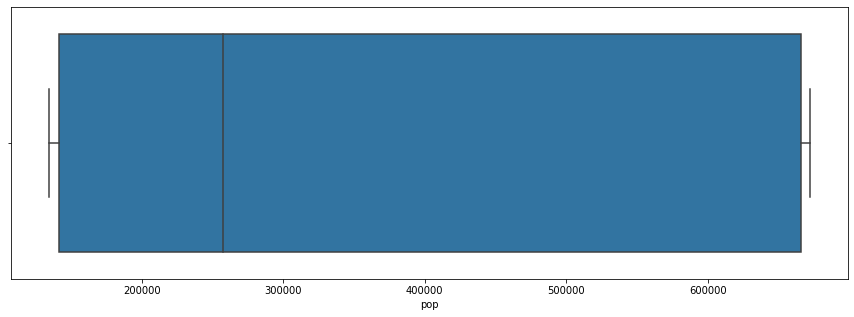

In [41]:
# диаграмма распределени значений ценаселения городов "pop"
plt.figure(figsize=(15,5))
sns.boxplot(x="pop", data=df_train)

# все значения в рамках диаграммы, все ок.

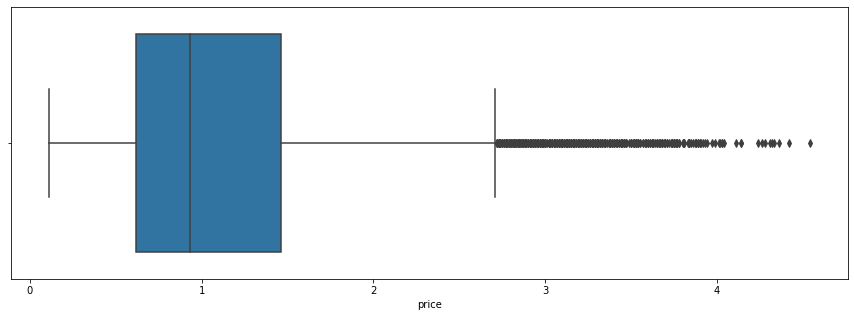

In [42]:
# диаграмма распределени значений цен "price"
plt.figure(figsize=(15,5))
sns.boxplot(x="price", data=df_train)

# есть значения выше максимума, т.е. потенциальные выбросы

In [43]:
df_train.loc[df_train['price'] > 2.5]

,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
1,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,plastic,1.5lt,2.86,6727.0
24,2012-01-31,Patra,38.24444,21.73444,164250.0,shop_6,kinder-cola,plastic,1.5lt,3.84,8361.0
27,2012-01-31,Patra,38.24444,21.73444,164250.0,shop_6,adult-cola,plastic,1.5lt,2.77,14917.0
36,2012-01-31,Thessaloniki,40.64361,22.93086,346502.0,shop_4,kinder-cola,plastic,1.5lt,2.80,11306.0
38,2012-01-31,Thessaloniki,40.64361,22.93086,346502.0,shop_4,adult-cola,plastic,1.5lt,2.99,12674.0
...,...,...,...,...,...,...,...,...,...,...,...
6438,2017-12-31,Athens,37.96245,23.68708,665871.0,shop_3,kinder-cola,plastic,1.5lt,4.03,5259.0
6441,2017-12-31,Athens,37.96245,23.68708,665871.0,shop_3,adult-cola,plastic,1.5lt,3.24,8773.0
6459,2017-12-31,Larisa,39.63689,22.41761,144302.0,shop_5,lemon-boost,plastic,1.5lt,2.82,9772.0
6470,2017-12-31,Patra,38.24444,21.73444,168501.0,shop_6,lemon-boost,plastic,1.5lt,2.72,16442.0


In [44]:
df_train.loc[df_train['price'] > 2.5].nunique()

# все значения цен > 2.5 принадлежат большим бутылкам (1 уникальное значение container/capacity по условию price > 2.5)
# это логично, не считаю данные значения выбросами.

date          72
city           5
lat            6
long           6
pop           30
shop           6
brand          5
container      1
capacity       1
price        157
quantity     582
dtype: int64

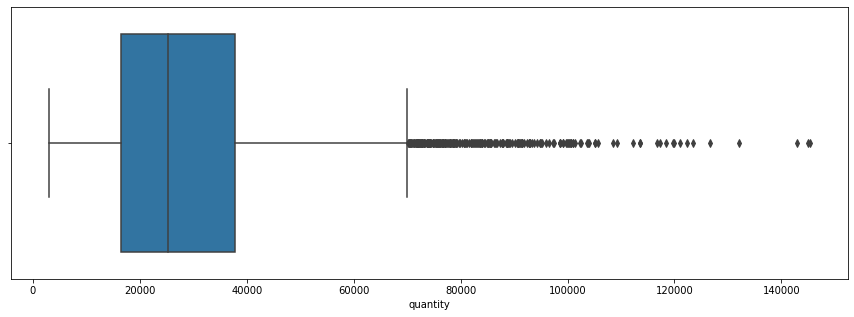

In [45]:
# диаграмма распределени значений количества напитков "quantity"
plt.figure(figsize=(15,5))
sns.boxplot(x="quantity", data=df_train)

# есть значения выше максимума, т.е. потенциальные выбросы

In [46]:
df_train.loc[df_train['quantity'] > 120000]

,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
391,2012-05-31,Patra,38.24444,21.73444,164250.0,shop_6,gazoza,can,330ml,0.24,126691.0
480,2012-06-30,Patra,38.24444,21.73444,164250.0,shop_6,gazoza,glass,500ml,0.45,144973.0
563,2012-07-31,Irakleion,35.32787,25.14341,134219.0,shop_2,gazoza,can,330ml,0.22,145287.0
625,2012-07-31,Patra,38.24444,21.73444,164250.0,shop_6,gazoza,can,330ml,0.22,142857.0
1474,2013-05-31,Patra,38.24444,21.73444,166301.0,shop_6,orange-power,can,330ml,0.21,132062.0
1649,2013-07-31,Patra,38.24444,21.73444,166301.0,shop_6,gazoza,glass,500ml,0.53,120975.0
2557,2014-05-31,Patra,38.24444,21.73444,167242.0,shop_6,gazoza,can,330ml,0.26,122389.0
2721,2014-07-31,Irakleion,35.32787,25.14341,136202.0,shop_2,gazoza,can,330ml,0.28,123384.0


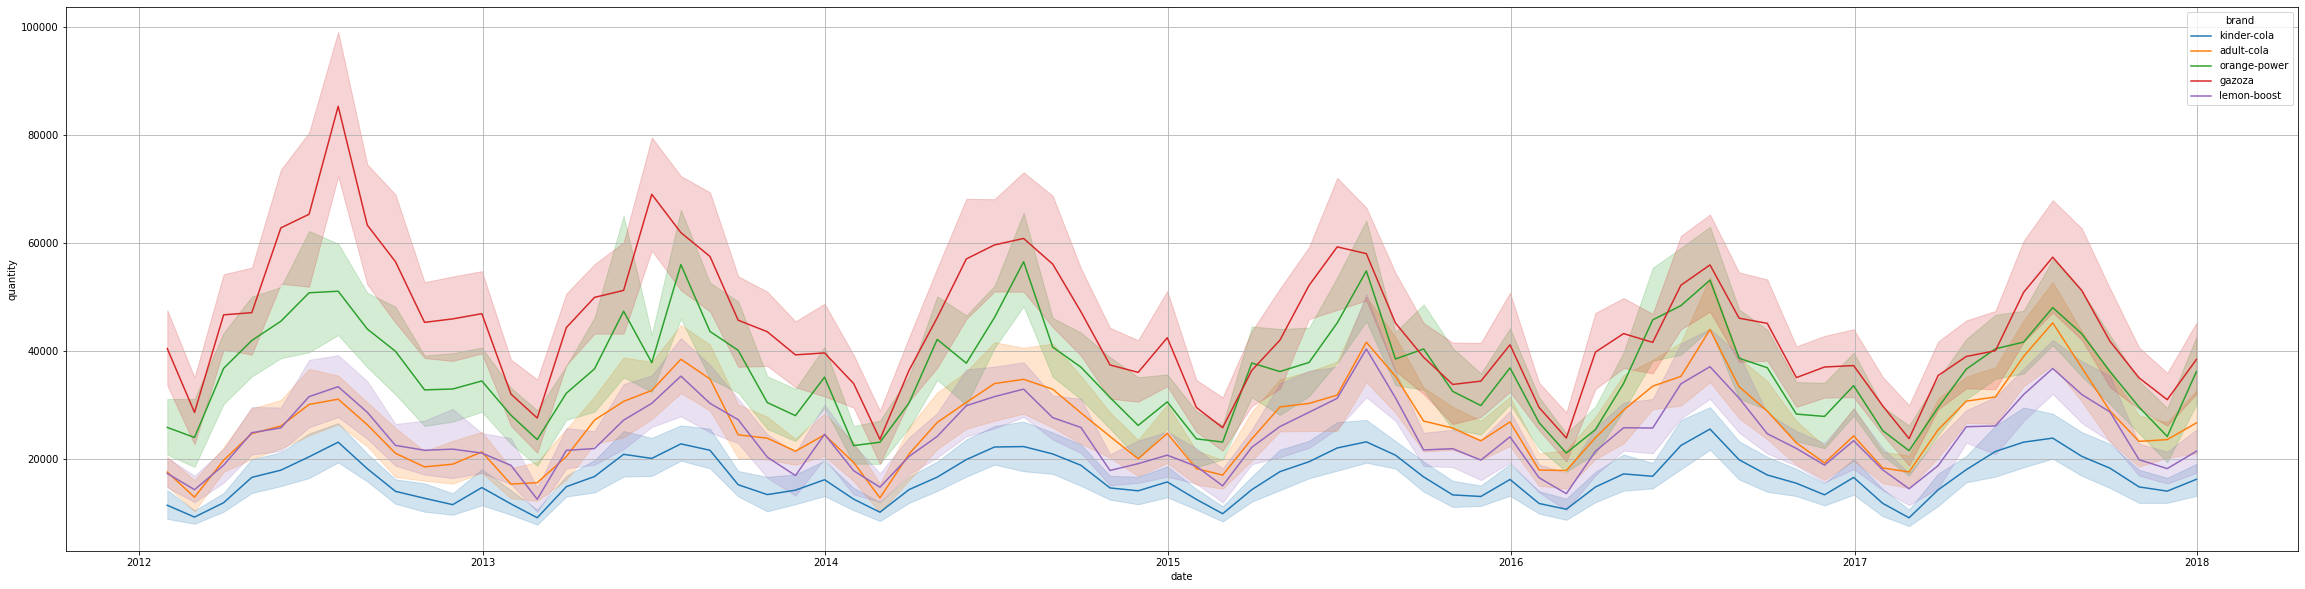

In [47]:
# график изменения количества единиц товаров брендов по месяцам
plt.figure(figsize=(40,10))
sns.lineplot(x=df_train['date'], y=df_train['quantity'], hue=df_train['brand'])
plt.grid(True)

# Пики продаж напитков приходятся на июнь-август, что логично. Значения, "quantity" которые можно принять за выбросы считаю таковыми не являются, это пиковые продажи в сезон.
# Также на графике отчетливо видно общее падение объемов потребления.

In [48]:
# дополнитело найдем выбросы методом Z-score:
outliers=[]
def find_outliers(data):
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        Z_score = (i-mean)/std
        if np.abs(Z_score)>threshold:
            outliers.append(i)
    
    return outliers
find_outliers(df_train["price"])

# считаю, что данные значения не являются выбросами, а есть естественным колебанием цен на напитки.

[3.84,
 3.63,
 3.67,
 3.67,
 3.68,
 3.81,
 3.68,
 3.63,
 3.86,
 3.94,
 3.92,
 3.63,
 3.88,
 3.85,
 3.68,
 4.02,
 3.65,
 3.76,
 3.74,
 3.65,
 3.77,
 3.77,
 4.32,
 3.7,
 3.8,
 3.74,
 3.59,
 3.75,
 3.74,
 3.75,
 3.81,
 3.99,
 3.91,
 3.67,
 3.71,
 4.14,
 3.73,
 3.89,
 3.74,
 3.75,
 4.26,
 3.97,
 3.66,
 4.36,
 3.69,
 3.9,
 3.59,
 4.04,
 3.62,
 3.78,
 3.8,
 3.9,
 3.6,
 4.14,
 3.64,
 3.75,
 3.6,
 3.84,
 3.72,
 4.33,
 4.31,
 3.84,
 4.42,
 3.61,
 3.61,
 3.65,
 3.78,
 3.59,
 3.87,
 3.88,
 3.7,
 3.62,
 3.84,
 4.01,
 3.93,
 4.11,
 4.54,
 3.76,
 3.76,
 3.71,
 3.65,
 3.76,
 4.03,
 4.28,
 3.89,
 3.68,
 4.24,
 4.03,
 3.83]

# 4. Визуализация данных

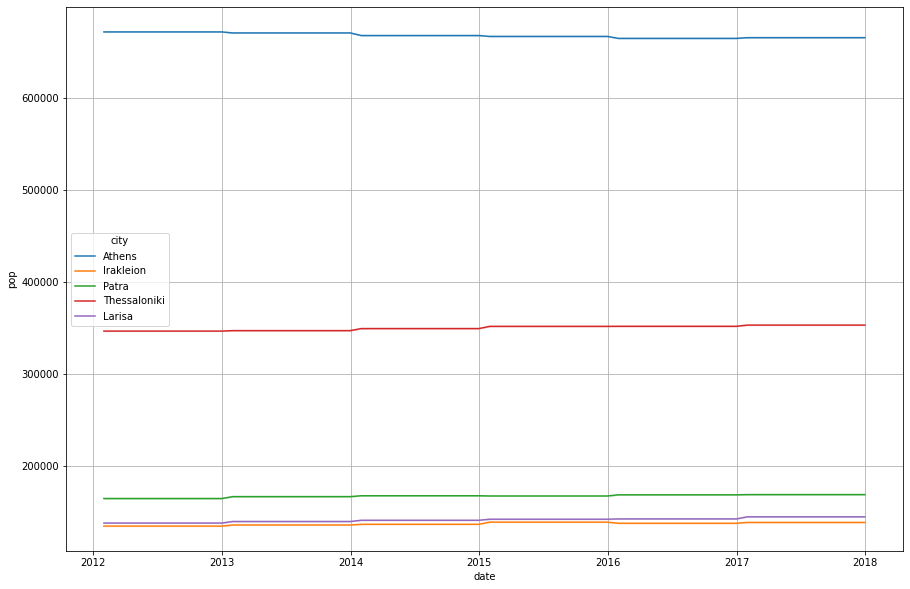

In [50]:
# график динамики изменения количества населения в городах
plt.figure(figsize=(15,10))
sns.lineplot(x=df_train['date'], y=df_train['pop'], hue=df_train['city'], data=df_train)
plt.grid(True)

# во всех городах, кроме Athens наблюдается незначительная положительная демографическая динамика, что в перспективе может привести к увеличению потребления продукции компании.

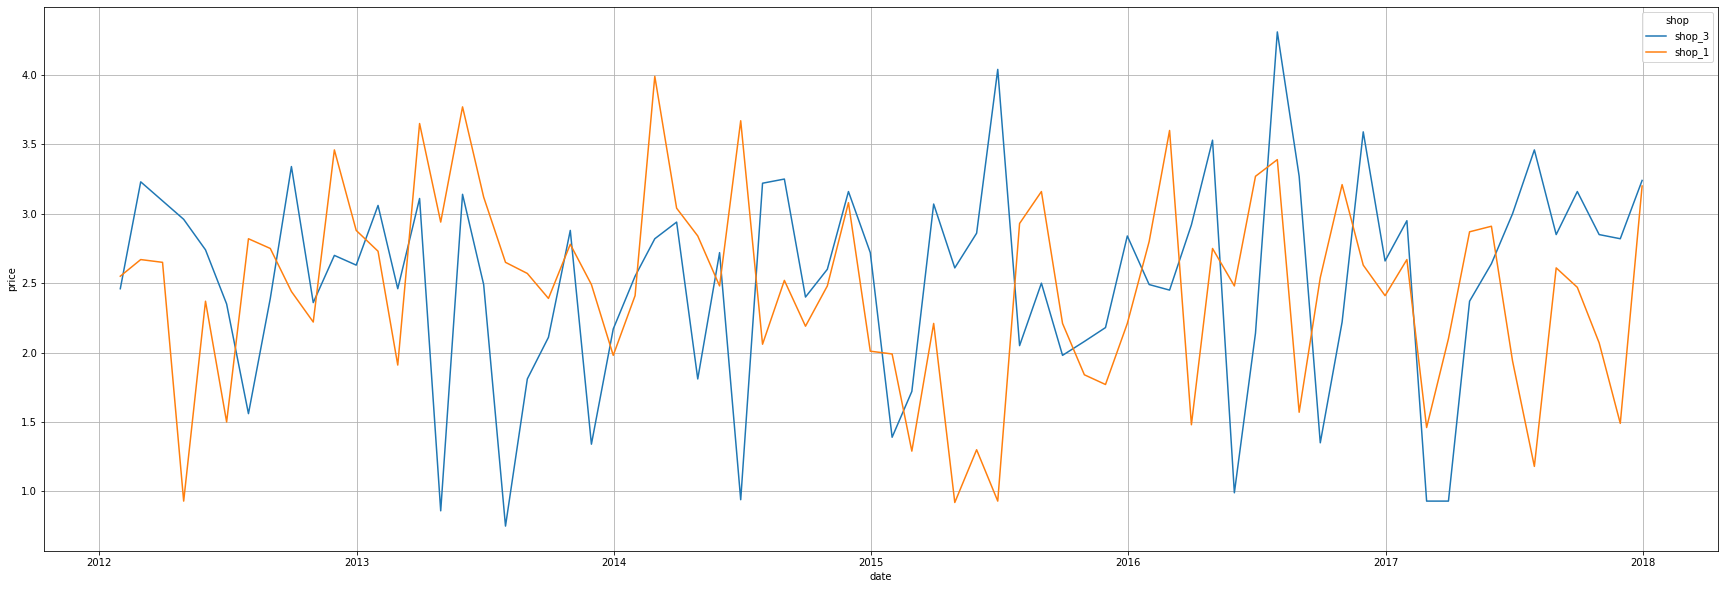

In [51]:
# график изменения цены больших бутылок бренда 'adult-cola' в городе 'Athens' по магазинам (аналогично можно делать для других брендов и городов).
plt.figure(figsize=(30,10))
data_1=df_train[(df_train['brand'] == 'adult-cola') & (df_train['container'] == 'plastic') & (df_train['city'] == 'Athens')]
sns.lineplot(x=data_1['date'], y=data_1['price'], hue=data_1['shop'], data=data_1)
plt.grid(True)

# как правило цена изменяется в одном направлении, но бывают периоды, когда в одном магазине дорожает, а в другом дешевеет.
# возможно это связано с проведением акций для уменьшения старых запасов продукции в одном из магазинов, хотя для этого было бы достаточно оставить прежнюю цену, на фоне подорожания в другом магазине.
# а возможно это действие для агрессивного привлечения клиентов, которые помимо "дешевого" напитка купят в магазине что-то еще. 

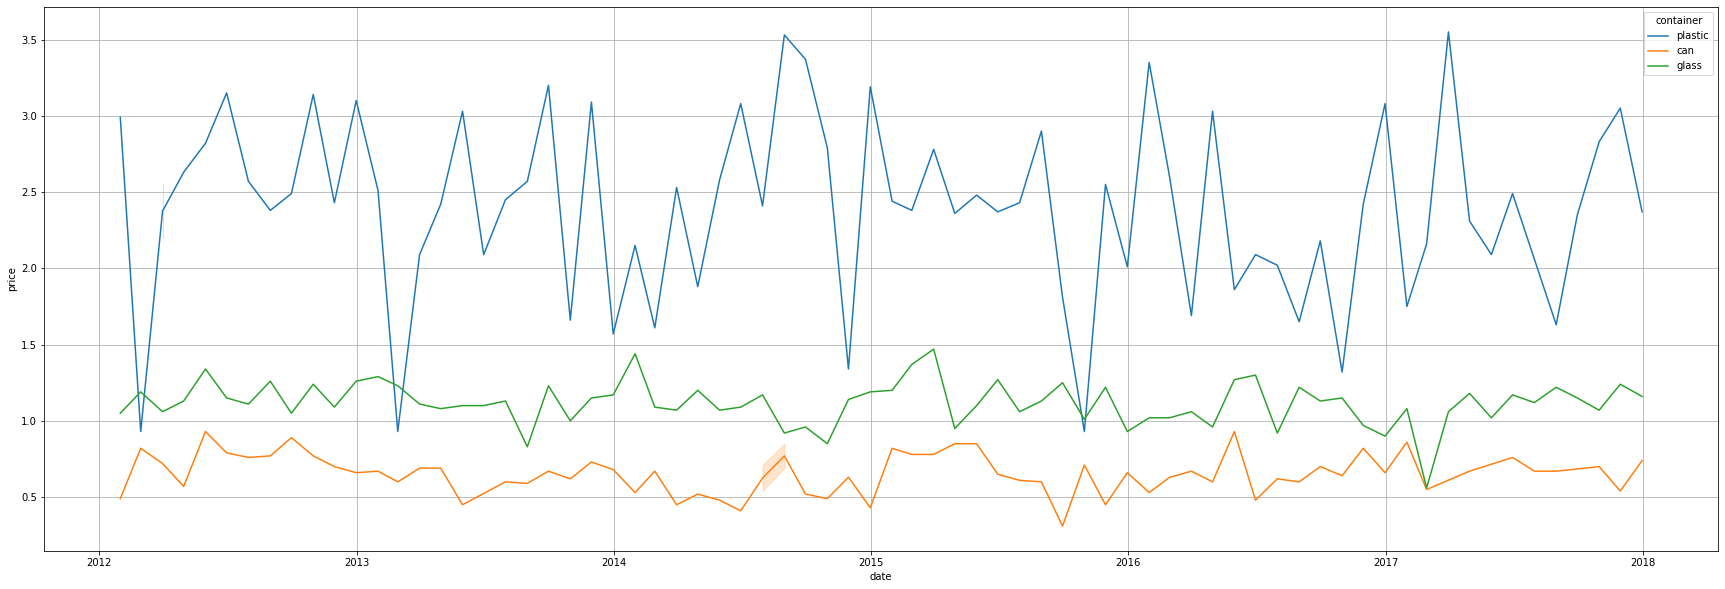

In [52]:
# график изменения цен на 'adult-cola' в городе 'Thessaloniki' по типам емкостей (пластик, стекло, банка).
plt.figure(figsize=(30,10))
data_2=df_train[(df_train['brand'] == 'adult-cola')&(df_train['city'] == 'Thessaloniki')]
sns.lineplot(x=data_2['date'], y=data_2['price'], hue=data_2['container'], data=data_2)
plt.grid(True)

# на изображении динамики цен на "банки" во второй половине 2014 заметен доверительный интервал, т.е. цена менялась несколько раз за месяц.

In [53]:
# детальное рассмотрение подтверждает что цена изменялась 2 раза в июле и августе 2014
import datetime 
data_2[(data_2['date'] > '2014-05-31') & (data_2['date'] < '2014-10-30') & (data_2['container'] == 'can')]

,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
2653,2014-06-30,Thessaloniki,40.64361,22.93086,349232.0,shop_4,adult-cola,can,330ml,0.41,76785.0
2738,2014-07-31,Thessaloniki,40.64361,22.93086,349232.0,shop_4,adult-cola,can,330ml,0.71,30879.0
2778,2014-07-31,Thessaloniki,40.64361,22.93086,349232.0,shop_4,adult-cola,can,330ml,0.54,63333.0
2827,2014-08-31,Thessaloniki,40.64361,22.93086,349232.0,shop_4,adult-cola,can,330ml,0.85,21736.0
2830,2014-08-31,Thessaloniki,40.64361,22.93086,349232.0,shop_4,adult-cola,can,330ml,0.69,41215.0
2966,2014-09-30,Thessaloniki,40.64361,22.93086,349232.0,shop_4,adult-cola,can,330ml,0.52,46229.0


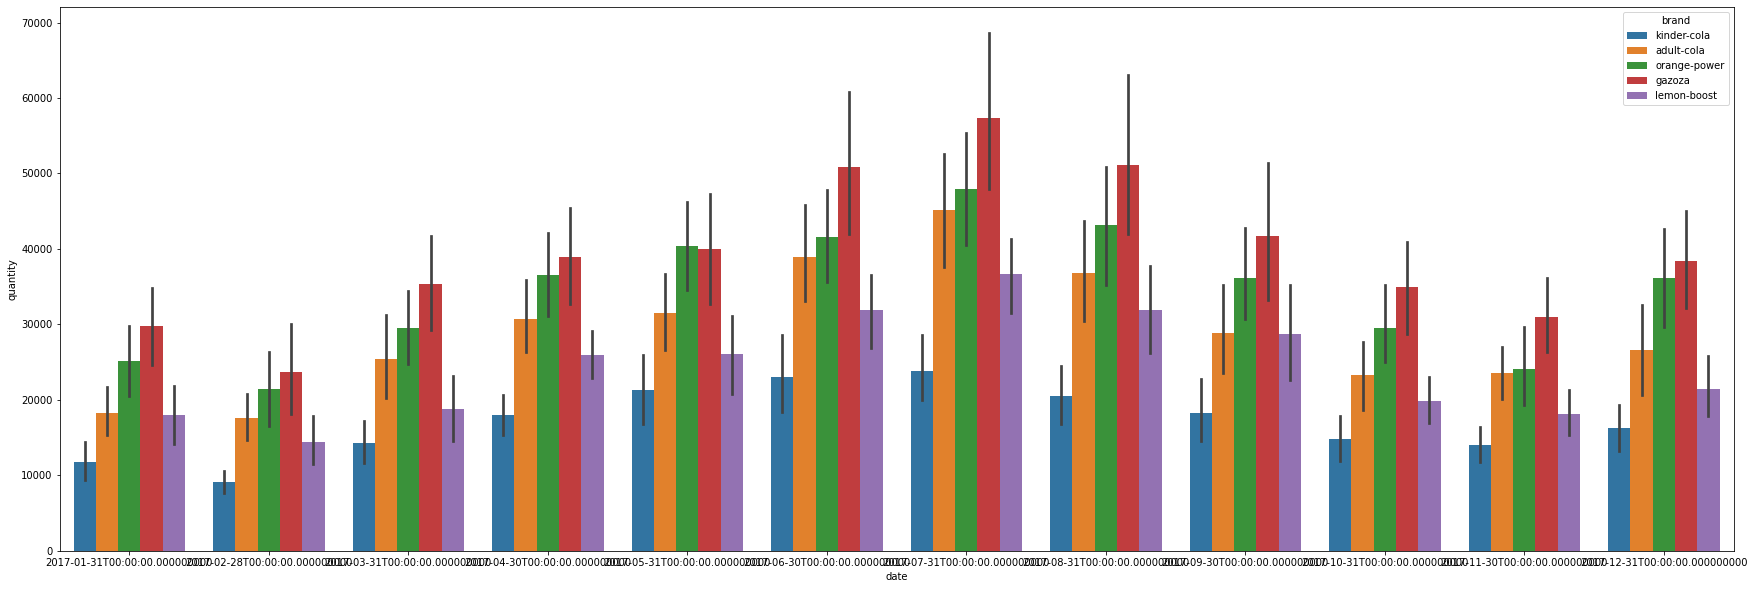

In [54]:
# сравнение брендов в 2017 году.
plt.figure(figsize=(30,10))
data_3=df_train[df_train['date'].dt.year == 2017]
ax = sns.barplot(x="date", y="quantity", hue="brand", data=data_3)

# наиболее популярным является напиток "gazoza"

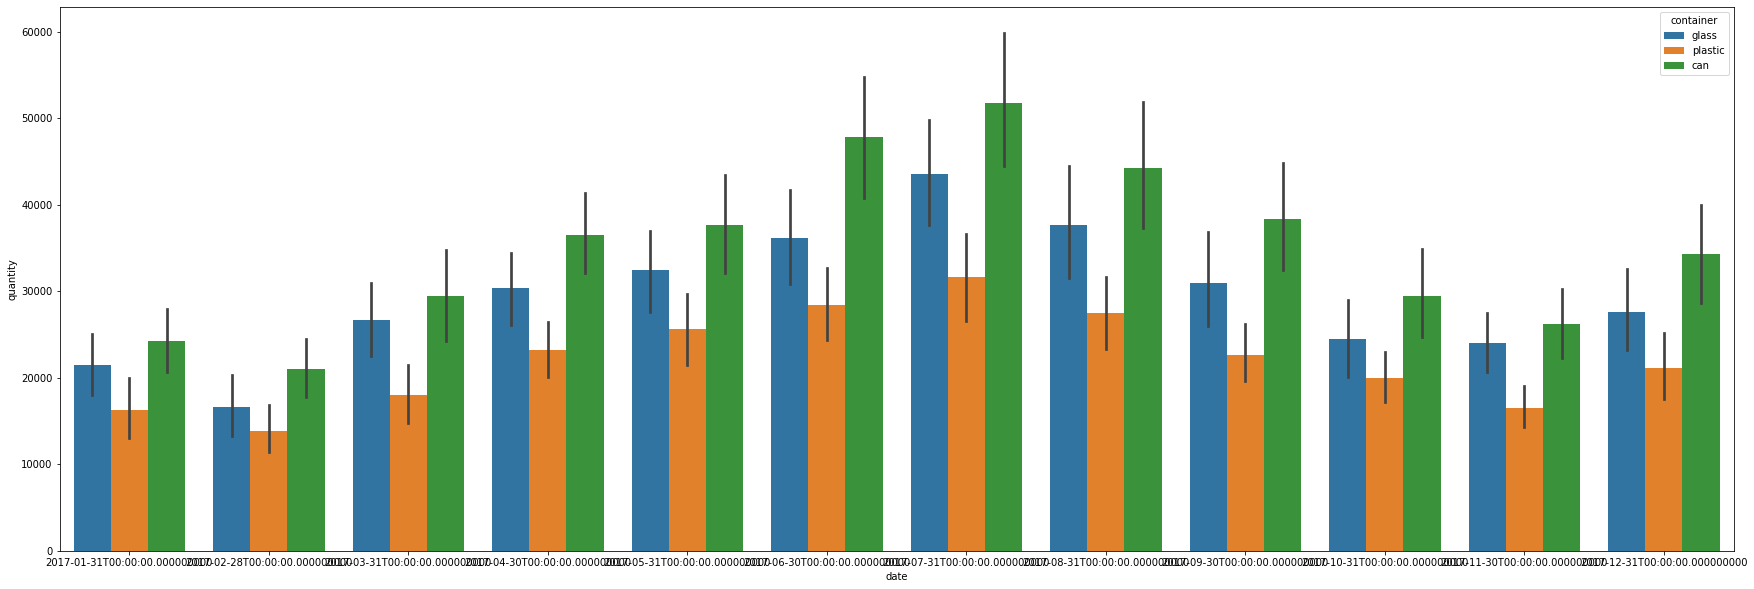

In [55]:
# сравнение видов емкости в 2017 году.
plt.figure(figsize=(30,10))
data_3=df_train[df_train['date'].dt.year == 2017]
ax = sns.barplot(x="date", y="quantity", hue="container", data=data_3)

# наиболее популярной является жестяная банка "can"

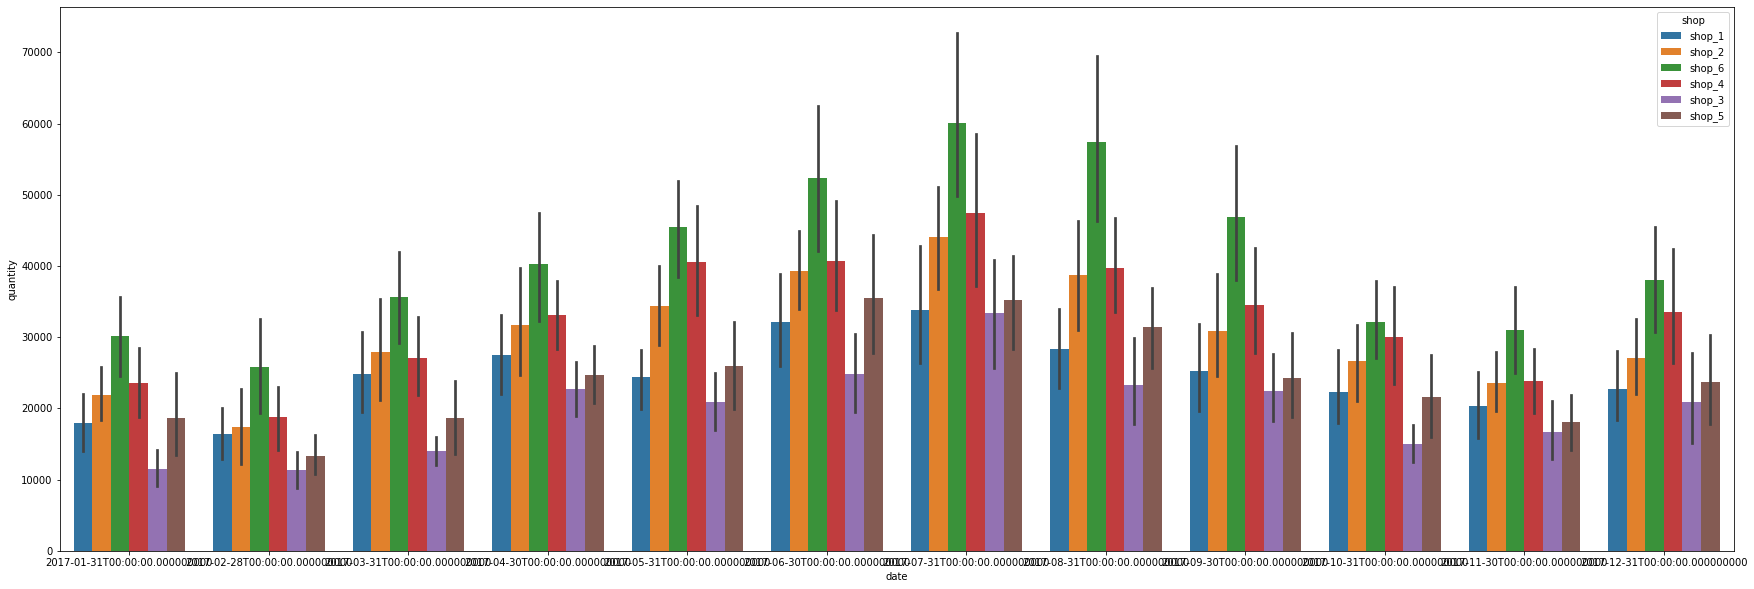

In [56]:
# сравнение магазинов в 2017 году.
plt.figure(figsize=(30,10))
data_3=df_train[df_train['date'].dt.year == 2017]
ax = sns.barplot(x="date", y="quantity", hue="shop", data=data_3)

# лидером среди магазинов является "shop_6" (город Patra)

# 5. Построение и оценка моделей
Создадим и обучим модель, делающую прогноз 'quantity'. 

In [57]:
df.head(3)

,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,glass,500ml,0.96,13280.0
1,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,plastic,1.5lt,2.86,6727.0
2,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,can,330ml,0.87,9848.0


In [58]:
# объемы напитков сильно зависят от сезона года, поэтому создадим новый предиктор 'month' - месяц в году.
df['month'] = df['date'].dt.month

# преобразуем новый предиктор в object для возможности последующей кодировки
df['month'] = df['month'].astype("object")

In [60]:
# кодирование one hot encoding при помощи get_dummies с удалением первых фиктивных столбцов для предупреждения мультиколлинеарности

df_OH = pd.get_dummies(df, columns = ["city","shop","brand", "container", "month"], drop_first=True)

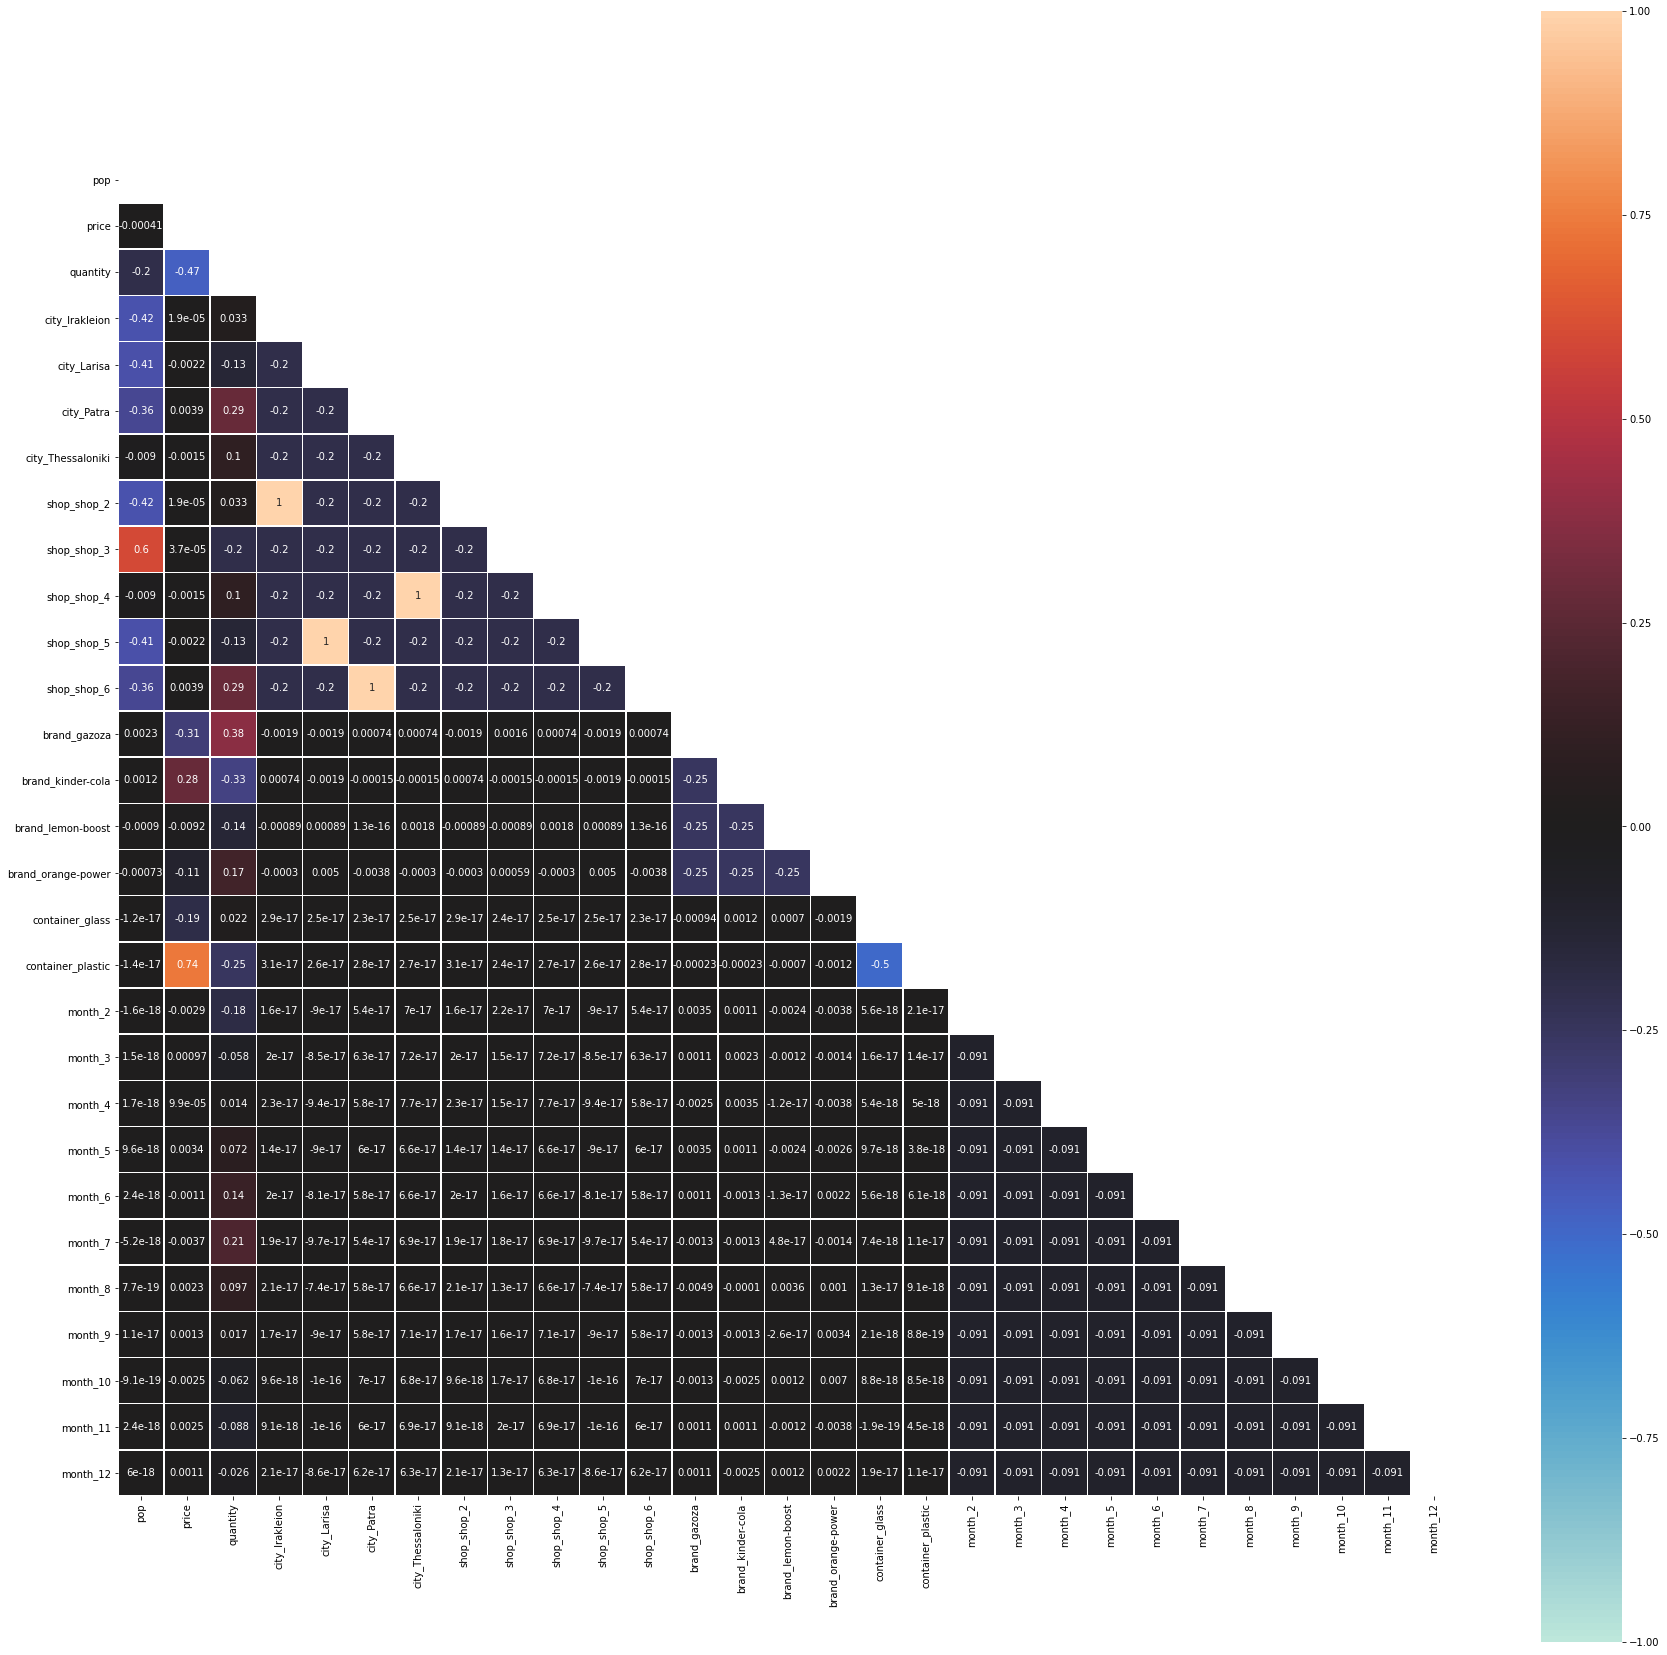

In [62]:
# построим матрицу корреляции
import matplotlib.pyplot as pl
matrix = np.triu(df_OH.corr())
pl.figure(figsize=(30, 30))
sns.heatmap(df_OH.corr(), vmin=-1.0, vmax=1.0, cmap="icefire", linewidths=.5, annot=True, annot_kws={"size":10}, square=True, mask=matrix)

# видим одинаковую корреляцию таргета с "shop" и "city", что логично. Для построения модели будем использовать только "shop"

In [63]:
# разъединим ранее соединенные датасеты
df_train_OH = df_OH.loc[: 6479]
df_test_OH = df_OH.loc[6480 :].reset_index(drop=True)
df_test = df.loc[6480 :].reset_index(drop=True)

# # удаление столбца 'quantity' в df_tedf_test_OHst, который появился после слияния с df_train и 'quantity', 'month' из тестового df_test
del df_test_OH['quantity']
df_test = df_test.drop(['quantity', 'month'], axis=1)

In [65]:
# импорт библиотек
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [67]:
# введем переменные для создания модели и получения прогноза: X - features, Y - target, X_test - тестовый датасет
X = df_train_OH.drop(["date", "lat", "long", "capacity", "quantity"], axis=1)
Y = df_train_OH['quantity']

X_test = df_test_OH.drop(["date", "lat", "long", "capacity"], axis=1)

In [68]:
# Нормализация данных разными методами

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

# Y = np.log(Y)

num_cols=['pop','price']
for i in num_cols:
  """QuantileTransformer"""
  X[i] = QuantileTransformer(output_distribution='normal').fit_transform(X[[i]])
  X_test[i] = QuantileTransformer(output_distribution='normal').fit_transform(X_test[[i]])

  """StandardScaler"""
  # X[i] = StandardScaler().fit_transform(X[[i]])

  """Normalizer"""
  # X[i] = Normalizer().fit_transform(X[[i]])

# Наилучший результат показал QuantileTransformer

In [69]:
# разделим набор данных на обучающий и проверочный
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state = 0)

In [70]:
# Сравнение работы разных моделей
TestModels = pd.DataFrame()
tmp = {}

classifiers = [
    linear_model.LinearRegression(),
    XGBRegressor(verbosity = 0),
    linear_model.TheilSenRegressor(),
    linear_model.ARDRegression(),    
    linear_model.LassoLars()   
    ]

for item in classifiers:
    my_model = item
    my_model.fit(X_train, Y_train)
    predictions = my_model.predict(X_valid)
    #print(my_model.predict(X_valid),'\n')
    tmp['MAE'] = round(mean_absolute_error(predictions, Y_valid),3)
    tmp['R2_score'] = round(r2_score(predictions, Y_valid),3)
    TestModels = TestModels.append([tmp])

TestModels.index = ['LinearRegression', 'XGBRegressor', 'TheilSenRegressor', 'ARDRegression', 'LassoLars']
TestModels

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.551e+01, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.272e+01, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.272e+01, with an active set of 11 regressors, and the smallest cholesky pivot elem

,MAE,R2_score
LinearRegression,5531.906,0.758
XGBRegressor,4770.138,0.799
TheilSenRegressor,5371.721,0.733
ARDRegression,5529.704,0.757
LassoLars,6101.840,0.632


In [ ]:
# наилучший результат получен при использовании XGBRegressor. Поробуем подбрать параметры XGBRegressor при помощи optuna для повышения производительности 

In [ ]:
!pip install optuna

In [104]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
        verbosity = 0
    )
    xgb = XGBRegressor(**xgb_params)
    xgb.fit(X_train, Y_train)
    predictions = xgb.predict(X_valid)
    # return round(mean_absolute_error(predictions, Y_valid),3) 
    return round(r2_score(predictions, Y_valid),3)

# study = optuna.create_study(direction="minimize")
study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2021-07-15 08:48:39,930] A new study created in memory with name: no-name-6b12c139-4062-4f56-a4e5-105392b744fe
[I 2021-07-15 08:48:50,702] Trial 0 finished with value: 0.535 and parameters: {'max_depth': 2, 'learning_rate': 0.0013779506701832535, 'n_estimators': 4030, 'min_child_weight': 2, 'colsample_bytree': 0.9025157299001692, 'subsample': 0.2995350220280294, 'reg_alpha': 0.041283549528704944, 'reg_lambda': 0.00018887369933007716}. Best is trial 0 with value: 0.535.
[I 2021-07-15 08:48:58,883] Trial 1 finished with value: -0.016 and parameters: {'max_depth': 3, 'learning_rate': 0.0015747598773638237, 'n_estimators': 3182, 'min_child_weight': 3, 'colsample_bytree': 0.801634896791334, 'subsample': 0.9746979648711476, 'reg_alpha': 34.05439578961895, 'reg_lambda': 72.96400743830121}. Best is trial 0 with value: 0.535.
[I 2021-07-15 08:49:01,575] Trial 2 finished with value: 0.911 and parameters: {'max_depth': 3, 'learning_rate': 0.06322910597267829, 'n_estimators': 1288, 'min_child_w

In [72]:
# автоматический подбор параметров выдал отличный результат, лучше чем LinearRegression

#  [I 2021-07-15 08:50:40,717] Trial 7 finished with value: 0.962 and parameters: {'max_depth': 4, 'learning_rate': 0.08553430165506055, 'n_estimators': 4282, 'min_child_weight': 5, 
# 'colsample_bytree': 0.4467307580247861, 'subsample': 0.9813696647726078, 'reg_alpha': 0.03585114055311988, 'reg_lambda': 6.789154486357946}. Best is trial 7 with value: 0.962.

xgb_params = dict(
    max_depth=4,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.08553430165506055,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=4282,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=5,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.4467307580247861,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.9813696647726078,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.03585114055311988,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=0.789154486357946,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
        verbosity = 0)     # cancel displaying warnings

xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, Y_train)
predictions_xgb = xgb.predict(X_valid)
print("r2_score: ", round(r2_score(predictions_xgb, Y_valid),3))

r2_score:  0.95


# 6. Прогноз "quantity" тестовых данных, выгрузка результата.

In [73]:
# прогноз 'quantity' используя ранее обученную модель predictions_xgb
predictions_test = xgb.predict(X_test)

In [74]:
# добавление столбца с прогнозными значениями в df_test
df_test['quantity'] = predictions_test

In [76]:
df_test.head(5)

,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,2018-01-31,Athens,37.97945,23.71622,664046.0,shop_1,kinder-cola,plastic,1.5lt,3.10,8165.243164
1,2018-01-31,Athens,37.97945,23.71622,664046.0,shop_1,kinder-cola,can,330ml,0.85,11326.643555
2,2018-01-31,Athens,37.97945,23.71622,664046.0,shop_1,adult-cola,glass,500ml,0.83,25640.498047
3,2018-01-31,Athens,37.97945,23.71622,664046.0,shop_1,orange-power,glass,500ml,0.54,39848.214844
4,2018-01-31,Athens,37.97945,23.71622,664046.0,shop_1,orange-power,plastic,1.5lt,0.83,32824.535156


In [77]:
# выгрузка файла 'test_.csv'
df_test.to_csv('test_.csv')
!cp test_.csv "drive/My Drive/"